# Limits to distributed training

This is the main Jupyter notebook for the paper "Limits to distributed training" by Ege Erdil and David Schneider-Joseph.

## Preliminaries

We start by importing the necessary modules and defining a few helper functions that will be useful later on.

In [1]:
import numpy as np
from functools import lru_cache
import matplotlib.pyplot as plt
from math import isqrt, prod, gcd
from itertools import product
from sympy import divisors as sympy_divisors
from gpu.gpu_model import GPU, V100_SXM2, A100, H100_SXM5, H100_SXM5_Zero_Latency, H100_PCIe, H100_SXM5_Superpod, H100_SXM5_Superpod_Zero_Latency, H100_SXM5_Superpod_Singleton, \
                               H100_SXM5_Global_NVLink, H100_SXM5_Global_NVLink_Zero_Latency, H100_SXM5_Infinite_Network_Zero_Latency, H100_Datacenter, gpu_list, gpu_dict
from bisect import bisect_left
from copy import deepcopy
from collections import namedtuple

seconds_in_year = 3.154e+7

@lru_cache(maxsize=None)
def divisors(N: int) -> list[int]:
    """Return a list of the divisors of N. We wrap calls to the sympy divisors function this way so the outputs get cached by lru_cache."""
    return sympy_divisors(N)

@lru_cache(maxsize=None)
def factorizations(N: int, count: int, div_constraints: list[int] | None = None) -> list[list[int]]:
    """Return all possible ordered factorizations of N into count terms such that the ith factor divides div_constraints[i]."""
    if div_constraints != None:
       assert count == len(div_constraints)

    if count == 0:
      if N == 1:
        return [[]]
      else:
        return []
    else:
      result = []

      if div_constraints == None:
        for d in divisors(N):
            f = factorizations(N//d, count-1)
            for L in f:
                result.append([d] + L)
      else:
         for d in divisors(gcd(N, div_constraints[0])):
            f = factorizations(N//d, count-1, div_constraints[1:])
            for L in f:
                result.append([d] + L)

      return result

@lru_cache(maxsize=None)
def parallelism_partitions(N_DP: int, N_TP_model: int, N_TP_ff: int, N_PP: int, N_EP: int, level_sizes: list[int]) -> list[tuple[int]]:
    """Given the combined parallelism degrees across all levels of the hierarchy,
    return a list of all possible breakdowns of these degrees into that hierarchy,
    each element a tuple of tuples of the form ((N_DP_level_0, N_DP_level1, …),
    (N_TP_model_level0, N_TP_model_level1, …), …), satisfying that prod(N_*_level_k)
    = level_sizes[k] and prod(N_i) = N_i."""

    parallelism = [N_DP, N_TP_model, N_TP_ff, N_PP, N_EP]
    N_GPU = prod(parallelism)
    result = []

    adjusted_level_sizes = []
    running_product = 1

    for level_size in level_sizes:
        running_product *= level_size
        if running_product < N_GPU:
           adjusted_level_sizes.append(level_size)
        else:
           adjusted_level_sizes.append(N_GPU//(running_product//level_size))
           break
    
    adjusted_level_sizes += [1] * (len(level_sizes) - len(adjusted_level_sizes))

    for f in product(*[factorizations(level_size, count=5) for level_size in adjusted_level_sizes]):
       if all([parallelism[i] % prod([q[i] for q in f]) == 0 for i in range(5)]):
            partition = tuple([[q[i] for q in f] + [parallelism[i]//prod([q[i] for q in f])] for i in range(5)])
            result.append(partition)

    return result

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.

    credit to lauritz v. thaulow of stackoverflow for the implementation
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before

## Scaling functions and communication primitives

In this section, we define functions characterizing the scaling behavior of quantities such as the sparsity factor, the critical batch size and the model depth; as well as a few primitives for computing the communication cost of standard operations such as all-reduce and point-to-point communication.

In [3]:
# prepare a list of numbers that are divisible by 2 many times so we can round the results of the three functions below to elements of this list
# this rounding ensures that the divisibility conditions needed for efficient parallelism are easy to satisfy when the cluster size is a power of 2
rounding_list = sorted([f * 2**i for (f, i) in product(range(1, 11, 2), range(60))])

def critical_batch_size(training_compute, seq_len, sparsity_factor=1):
    bs = sparsity_factor**(1/2) * (training_compute/3e23)**(1/6) * 2048*2048/seq_len
    return sparsity_factor * take_closest(rounding_list, bs/sparsity_factor)

def critical_batch_size_deepseek(training_compute, seq_len, sparsity_factor=1):
    bs = (1/seq_len) * sparsity_factor**(1/2) * 0.2920 * training_compute**(0.3271)
    return sparsity_factor * take_closest(rounding_list, bs/sparsity_factor)

# based on fitting a power law to the scaling used in hoffmann et al. (2022)
def number_of_layers(d_model, d_ff):
    L = 0.10056 * (d_model*d_ff)**(0.3751)
    return take_closest(rounding_list, L)

def calc_sparsity_factor(d_model, d_ff):
    sf = 8 * (d_model*d_ff/(4 * 12288**2))**(0.5)
    return take_closest(rounding_list, sf)

def compute_optimal_dataset_size(number_of_params: int) -> int:
    return 20*number_of_params # the chinchilla scaling law for the dataset size of a compute-optimal model

# compute how long an allreduce repeated some number of times takes in units of seconds
def allreduce_time_sec(gpu: GPU, participants: int, words: int, network_level: int, cluster_size: int, repeat_sequential=1, repeat_parallel=1) -> tuple:
    bandwidth_time_sec = 2 * (participants - 1) * words * repeat_sequential * repeat_parallel * gpu.bytewidth/(cluster_size*gpu.network_bandwidths_per_level_Bps[network_level]/2)
    latency_time_sec = 2 * repeat_sequential * gpu.network_latency_per_level_seconds[network_level] if participants > 1 else 0

    return latency_time_sec, bandwidth_time_sec

# compute how long a point-to-point communication repeated some number of times takes in units of seconds
def p2p_time_sec(gpu: GPU, words: int, network_level: int, cluster_size: int, repeat_sequential=1, repeat_parallel=1) -> tuple:
    bandwidth_time_sec = words * repeat_sequential * repeat_parallel * gpu.bytewidth/(cluster_size*gpu.network_bandwidths_per_level_Bps[network_level]/2)
    latency_time_sec = repeat_sequential * gpu.network_latency_per_level_seconds[network_level]

    return latency_time_sec, bandwidth_time_sec

# how much memory we need in the cluster for a training run
def training_memory_reqs_bytes(number_of_params, precision_bytes, optimizer_overhead_factor, d_model, d_ff, sparsity_factor, N_PP, N_DP, microbatch_size_tokens, layers, \
                               recompute_activations: bool | None, zero_bubble_pp: bool):
    parameters_memory_bytes = number_of_params*precision_bytes*N_DP # we assume parameters are not sharded across DP ranks to avoid extra communication during PP
    optimizer_memory_bytes = number_of_params*precision_bytes*optimizer_overhead_factor # optimizer states are sharded across DP ranks

    if zero_bubble_pp: # zero bubble pipeline parallelism implementation follows qi et al. (2023)
        microbatches_kept_in_memory = 2*N_PP - 1
    else:
        microbatches_kept_in_memory = N_PP
    
    if recompute_activations == True: # if we recompute activations, we only store the initial hidden state for each microbatch and recompute other activations with a second fwd pass
        activations_memory_bytes = d_model*precision_bytes*microbatch_size_tokens*microbatches_kept_in_memory*N_DP*sparsity_factor # we multiply by N_PP because in 1F1B the number of live microbatches in the pipeline is at most N_PP
    elif recompute_activations == False:
        activations_memory_bytes = (d_model+d_ff)*precision_bytes*microbatch_size_tokens*microbatches_kept_in_memory*layers*N_DP*sparsity_factor
    else: # if recompute_activations is neither true nor false, then we just don't model the memory cost of activations
        activations_memory_bytes = 0

    return parameters_memory_bytes + optimizer_memory_bytes + activations_memory_bytes

## Main functions

This section defines three functions:

- **training_results**: This method takes a GPU, a model architecture and a parallelism setup and computes how long the training of the model with that setup will take.

- **optimal_parallelism**: This method takes a GPU, a model architecture and a cluster size, and searches over parallelism setups to determine which one can train the model in the least amount of time. If peak utilization can be achieved by multiple different setups, the symmetry is broken by picking the method that achieves the smallest network communication time.

- **cluster_size_required**: This method takes a GPU, an amount of time, and information about the model architecture; and determines what cluster size is required to train the specified model on the given GPU on less than the given amount of time.

More detailed specifications for each function (including the types of all of their inputs and their outputs) is available in the comments above the function definitions.

In [4]:
## training_results: computes how long a training run with the given parameters should take
##
## variables:
##
## d_model: model dimension
## d_ff: feedforward dimension
## layers: number of layers
## sparsity_factor: self-explanatory
## num_of_microbatches: number of microbatches in a pipeline, so the total number of microbatches is (num_of_microbatches)*N_DP
## N_X_tup: a list or tuple of length equal to the number of network hierarchy levels. for instance, N_DP_tup = [2, 4, 8] means 2-way DP inside nodes, 2*4=8-way DP inside superpods,
##          2*4*8=64-way DP in total
## pp_interleaving_factor: the pipeline interleaving factor
## overlap_X: whether to overlap network communications associated with the type of parallelism X with computation. 1 means overlap, 0 means don't overlap, behavior ill-defined
##            for other values
##
## returns:
##
## total_time (seconds), utilization_rate (dimensionless), tp_comm_time (seconds), dp_comm_time (seconds), pp_ep_comm_time (seconds)


def training_results(gpu, d_model, d_ff, layers, sparsity_factor, batch_size, seq_len, num_of_microbatches, N_DP_tup, N_TP_model_tup, N_TP_ff_tup, N_PP_tup, N_EP_tup, pp_interleaving_factor=1, \
                      zero_bubble_pp=False, recompute_activations=None, overlap_TP=1, overlap_DP=1, overlap_PP=1):
    # compute total parallelism degrees from the tuples defining partition across the network hierarchy
    N_EP = prod(N_EP_tup)
    N_DP = prod(N_DP_tup)
    N_TP_model = prod(N_TP_model_tup)
    N_TP_ff = prod(N_TP_ff_tup)
    N_PP = prod(N_PP_tup)

    if zero_bubble_pp:
        assert num_of_microbatches >= (2*N_PP - 1) # if using zero bubble PP, we require the number of microbatches to be at least 2*N_PP - 1 to achieve no pipeline bubble during training
        assert pp_interleaving_factor == 1 # we also require the pipeline interleaving factor to be equal to one

    num_levels = len(gpu.level_sizes) + 1 # the number of levels in the network hierarchy

    N = N_DP * N_TP_model * N_TP_ff * N_PP * N_EP # the total cluster size
    N_param = 2*d_model*d_ff*layers*sparsity_factor
    cost_fwd_pass_fma = N_param/sparsity_factor # the number of FMAs we need for a forward pass

    N_TP = N_TP_model * N_TP_ff
    D = compute_optimal_dataset_size(N_param) # the compute-optimal dataset size

    # pp_interleaving_factor = 1

    arithmetic_time_sec = 6*cost_fwd_pass_fma*batch_size*seq_len/(gpu.max_flop_per_s*N) # how much the arithmetic involved in a forward and backward pass should take at perfect utilization

    # now, compute how long the matrix multiplications actually take
    # multiplied by 3 because of once per fwd and twice per bwd pass, by L/N_PP because each PP stage handles that many layers, and by num_of_microbatches because each PP stage sees that many microbatches
    real_matmul_time_sec = 3 * (layers//N_PP) * (sparsity_factor//N_EP) * num_of_microbatches * \
                                    (gpu.matmul_time_seconds(d_ff//N_TP_ff, d_model//N_TP_model, batch_size*seq_len//(N_DP*num_of_microbatches*sparsity_factor)) + \
                                    gpu.matmul_time_seconds(d_model//N_TP_model, d_ff//N_TP_ff, batch_size*seq_len//(N_DP*num_of_microbatches*sparsity_factor)))

    dp_comm_time_sec = 0
    dp_latency_time_sec = 0

    tp_comm_time_sec = 0
    tp_latency_time_sec = 0

    pp_ep_comm_time_sec = 0
    pp_ep_latency_time_sec = 0

    ## compute hierarchical all-reduce costs in units of seconds for DP and TP
    for level in range(len(N_DP_tup)):
      local_dp_latency_sec, local_dp_comm_sec = allreduce_time_sec(gpu, N_DP_tup[level], N_param, level, N, repeat_sequential=1, repeat_parallel=prod(N_DP_tup[(level+1):]))
      dp_latency_time_sec += local_dp_latency_sec
      dp_comm_time_sec += local_dp_comm_sec

      local_tp_ff_latency_sec, local_tp_ff_comm_sec = allreduce_time_sec(gpu, N_TP_model_tup[level], d_ff, level, N, repeat_sequential=2*layers, \
                                                                         repeat_parallel=batch_size*seq_len*prod(N_TP_model_tup[(level+1):]))
      local_tp_model_latency_sec, local_tp_model_comm_sec = allreduce_time_sec(gpu, N_TP_ff_tup[level], d_model, level, N, repeat_sequential=2*layers, \
                                                                               repeat_parallel=batch_size*seq_len*prod(N_TP_ff_tup[(level+1):]))

      tp_comm_time_sec += local_tp_ff_comm_sec + local_tp_model_comm_sec
      tp_latency_time_sec += local_tp_ff_latency_sec + local_tp_model_latency_sec
    
    for pp_level, ep_level in product(range(num_levels), range(-1, num_levels)):
      ## assuming that each layer routes to experts uniformly at random, compute the probability that the lowest level of hierarchy that the current and the next expert share is ep_level
      ## if ep_level = -1, this corresponds to the case when the two experts are identical, so no EP communication needs to happen
      if ep_level == -1:
        ep_proba = 1/N_EP
      else:
        ep_proba = (prod(N_EP_tup[:ep_level+1]) - prod(N_EP_tup[:ep_level]))/N_EP

      level = max(pp_level, ep_level) ## at a pipeline communication boundary, we have to assume the worst about the network hierarchy level we must send information through

      ## compute the communication cost at PP communication boundaries
      if pp_level != num_levels - 1:
        local_pp_latency_sec, local_pp_comm_sec = p2p_time_sec(gpu, d_model, level, N, \
                                                                          repeat_sequential=2*prod(N_PP_tup[(pp_level+1):])*(N_PP_tup[pp_level]*pp_interleaving_factor - pp_interleaving_factor), \
                                                                          repeat_parallel=batch_size*seq_len)
      else:
        local_pp_latency_sec, local_pp_comm_sec = p2p_time_sec(gpu, d_model, level, N, repeat_sequential=2*(N_PP_tup[pp_level]*pp_interleaving_factor - 1), \
                                                                          repeat_parallel=batch_size*seq_len)

      if ep_level >= 0: ## handle the case when EP communication needs to happen at layers that are not PP communication boundaries
        local_ep_latency_sec, local_ep_comm_sec = p2p_time_sec(gpu, d_model, ep_level, N, repeat_sequential=2*(layers - N_PP*pp_interleaving_factor), \
                                                                          repeat_parallel=batch_size*seq_len)
      else:
        local_ep_latency_sec, local_ep_comm_sec = (0, 0)

      pp_ep_comm_time_sec += ep_proba * (local_pp_comm_sec + local_ep_comm_sec)
      pp_ep_latency_time_sec += ep_proba * (local_pp_latency_sec + local_ep_latency_sec)

    if recompute_activations == True: # if we're recomputing activations inside pipeline stages, we'll need more computation and TP communication, so adjust for that
        real_matmul_time_sec *= 1 + 1/3 # overall arithmetic time goes up by one fwd pass, so a third of a fwd + bwd pass

        tp_comm_time_sec *= 1 + 1/2 # tp comm time goes up by 50%
        tp_latency_time_sec *= 1 + 1/2

        pp_ep_comm_time_sec *= 1 + 1/2 # same with pp and ep comm time
        pp_ep_latency_time_sec *= 1 + 1/2

    nonoverlapped_network_time_sec = (1-overlap_DP)*dp_comm_time_sec + (1-overlap_PP)*pp_ep_comm_time_sec + (1-overlap_TP)*tp_comm_time_sec
    overlapped_network_time_sec = overlap_DP*dp_comm_time_sec + overlap_PP*pp_ep_comm_time_sec + overlap_TP*tp_comm_time_sec

    latency_time_sec = dp_latency_time_sec + tp_latency_time_sec + pp_ep_latency_time_sec

    if zero_bubble_pp:
        pipeline_bubble_fraction = 0
    else:
        z = (pp_interleaving_factor-1)*max(0, N_PP - num_of_microbatches)
        pipeline_bubble_fraction = (z + N_PP - 1)/(N_PP + pp_interleaving_factor*num_of_microbatches + z - 1)

    total_time_sec = latency_time_sec + (max(real_matmul_time_sec, overlapped_network_time_sec) + nonoverlapped_network_time_sec)/(1 - pipeline_bubble_fraction)

    return (D/(batch_size*seq_len))*total_time_sec, arithmetic_time_sec/total_time_sec, \
           tp_comm_time_sec*(D/(batch_size*seq_len)), dp_comm_time_sec*(D/(batch_size*seq_len)), pp_ep_comm_time_sec*(D/(batch_size*seq_len)), (D/(batch_size*seq_len))*latency_time_sec

## optimal_parallelism: searches for the optimal way to parallelize a training run with given specs over a given cluster size
##
## variables:
##
## d_model: model dimension
## d_ff: feedforward dimension
## layers: number of layers
## sparsity_factor: self-explanatory
## batch_size: self-explanatory, in units of sequences
## seq_len: sequence length, in units of tokens
## N: number of GPUs in the cluster
## gpu: model of GPU in the cluster, string-valued
## overlap_X: whether to overlap network communications associated with the type of parallelism X with computation. 1 means overlap, 0 means don't overlap, behavior ill-defined
##            for other values
## interleaving: whether to enable pipeline interleaving
##
## returns: optimal parallelism setup that is found as a result of the search, see time_for_training comments for elaboration on the formatting of e.g. N_DP_tup and similar variables

@lru_cache(maxsize=None)
def optimal_parallelism(gpu: GPU, d_model, d_ff, layers, sparsity_factor, batch_size, seq_len, N, zero_bubble_pp=False, overlap_TP=1, overlap_DP=1, overlap_PP=1, interleaving=True):
    best_time_sec = np.inf

    N_TP_model_opt = None
    N_TP_ff_opt = None
    N_DP_opt = None
    N_PP_opt = None
    N_EP_opt = None

    N_TP_model_tup_opt = None
    N_TP_ff_tup_opt = None
    N_DP_tup_opt = None
    N_PP_tup_opt = None
    N_EP_tup_opt = None

    num_of_microbatches_opt = None
    utilization_opt = None
    pp_interleaving_factor_opt = None
    recompute_activations_opt = None

    tp_time_sec_opt = None
    pp_time_sec_opt = None
    dp_time_sec_opt = None
    latency_time_sec_opt = None

    N_param = 2*d_model*d_ff*layers*sparsity_factor
    batch_size_tokens = batch_size*seq_len

    gpu_optimistic = deepcopy(gpu)
    gpu_optimistic.network_bandwidths_per_level_Bps = (max(gpu.network_bandwidths_per_level_Bps),)
    gpu_optimistic.network_latency_per_level_seconds = (min(gpu.network_latency_per_level_seconds),)
    gpu_optimistic.level_sizes = ()

    for i in range(1, len(gpu.level_sizes)):
        if N > prod(gpu.level_sizes[:i]):
            assert N % prod(gpu.level_sizes[:i]) == 0 # if the cluster size N is big enough to not fit inside some level of the hierarchy, assert divisibility by the size of that level

    N_EP = gcd(N, sparsity_factor)

    for (N_TP, N_DP, N_PP) in factorizations(N//N_EP, count=3, div_constraints=(d_model*d_ff, batch_size_tokens, layers)):
        for N_TP_ff in [d for d in divisors(N_TP) if d >= isqrt(N_TP) and d <= 4*isqrt(N_TP)]: # pick a factorization N_TP = N_(TP, ff) * N_(TP, model)
            N_TP_model = N_TP//N_TP_ff
            # microbatch_candidates = divisors(batch_size//(N_DP))
            microbatch_candidates = [d for d in divisors(batch_size_tokens//(sparsity_factor*N_DP)) if d >= (2*N_PP - 1 if zero_bubble_pp else N_PP)]
            if len(microbatch_candidates) == 0:
                continue

            for num_of_microbatches in [min(microbatch_candidates)]: # we assume each microbatch in a pipeline must be a full sequence, so the number of microbatches divides (batch size)/N_DP
                microbatch_size_tokens = batch_size_tokens//(sparsity_factor*N_DP*num_of_microbatches)
                if d_model % N_TP_model != 0 or d_ff % N_TP_ff != 0:
                    continue
                for recompute_activations in [None]:
                    if N*gpu.memory_bytes < training_memory_reqs_bytes(N_param, gpu.bytewidth, 4, d_model, d_ff, sparsity_factor, N_PP, N_DP, microbatch_size_tokens, \
                                                                       layers, recompute_activations, zero_bubble_pp):
                        continue
                
                    if interleaving: # if pipeline interleaving is enabled, search over possible interleaving degrees
                                        # except we don't do this and just set interleaving = layers/N_PP when N_PP > 1, else interleaving = 1 to save time
                        # interleaving_list = custom_divisors(layers//N_PP)
                        if (not zero_bubble_pp) and N_PP > 1:
                            interleaving_list = [layers//N_PP]
                        else:
                            interleaving_list = [1]
                    else:
                        interleaving_list = [1]

                    for pp_interleaving_factor in interleaving_list:
                        # if a network with one level of hierarchy that's as optimistic as possible cannot beat the current best result, this branch cannot improve on the current best, so skip it
                        time_sec, utilization, tp_time_sec, dp_time_sec, pp_time_sec, latency_time_sec = \
                        training_results(gpu_optimistic, d_model, d_ff, layers, sparsity_factor, batch_size, seq_len, num_of_microbatches, (N_DP,), (N_TP_model,), (N_TP_ff,), (N_PP,), (N_EP,), \
                                                pp_interleaving_factor, zero_bubble_pp, recompute_activations, overlap_TP, overlap_DP, overlap_PP)
                        if not (time_sec < best_time_sec or \
                                (time_sec == best_time_sec and tp_time_sec_opt != None and tp_time_sec + dp_time_sec + pp_time_sec < tp_time_sec_opt + pp_time_sec_opt + dp_time_sec_opt)):
                            continue

                        # loop over all possible ways of partitioning the parallelism degrees across the network hierarchy
                        for (N_DP_tup, N_TP_model_tup, N_TP_ff_tup, N_PP_tup, N_EP_tup) in parallelism_partitions(N_DP, N_TP_model, N_TP_ff, N_PP, N_EP, gpu.level_sizes):
                            time_sec, utilization, tp_time_sec, dp_time_sec, pp_time_sec, latency_time_sec = \
                            training_results(gpu, d_model, d_ff, layers, sparsity_factor, batch_size, seq_len, num_of_microbatches, N_DP_tup, N_TP_model_tup, N_TP_ff_tup, N_PP_tup, N_EP_tup, \
                                                pp_interleaving_factor, zero_bubble_pp, recompute_activations, overlap_TP, overlap_DP, overlap_PP)

                            # update the optimal parallelism strategy if either it achieves a better training time than the old strategy, or achieves the same time but needs less network communication time
                            if time_sec < best_time_sec or (time_sec == best_time_sec and tp_time_sec_opt != None and tp_time_sec + dp_time_sec + pp_time_sec < tp_time_sec_opt + pp_time_sec_opt + dp_time_sec_opt):
                            #if time < best_time:
                                N_TP_model_tup_opt, N_TP_ff_tup_opt, N_DP_tup_opt, N_PP_tup_opt, N_EP_tup_opt = N_TP_model_tup, N_TP_ff_tup, N_DP_tup, N_PP_tup, N_EP_tup
                                N_TP_model_opt, N_TP_ff_opt, N_DP_opt, N_PP_opt, N_EP_opt = N_TP_model, N_TP_ff, N_DP, N_PP, N_EP

                                tp_time_sec_opt, pp_time_sec_opt, dp_time_sec_opt, latency_time_sec_opt = tp_time_sec, pp_time_sec, dp_time_sec, latency_time_sec

                                num_of_microbatches_opt = num_of_microbatches
                                pp_interleaving_factor_opt = pp_interleaving_factor
                                recompute_activations_opt = recompute_activations

                                best_time_sec = time_sec
                                utilization_opt = utilization


    return N_DP_opt, N_TP_model_opt, N_TP_ff_opt, N_PP_opt, N_EP_opt, N_DP_tup_opt, N_TP_model_tup_opt, N_TP_ff_tup_opt, N_PP_tup_opt, N_EP_tup_opt, \
           num_of_microbatches_opt, pp_interleaving_factor_opt, recompute_activations_opt, utilization_opt, \
           best_time_sec/seconds_in_year, tp_time_sec_opt, dp_time_sec_opt, pp_time_sec_opt, latency_time_sec_opt

## cluster_size_required: searches for the optimal way to parallelize a training run with given specs over a given cluster size
##
## variables:
##
## d_model: model dimension
## d_ff: feedforward dimension
## number_of_layers: a function of type (int, int) -> int that takes (d_model, d_ff) as input and returns the number of layers
## calc_sparsity_factor: a function of type (int, int) -> int that takes (d_model, d_ff) as input and returns the sparsity factor
## critical_batch_size: a function of type (int, int, int) -> int that takes (training compute, sequence length, sparsity factor) as input and returns the critical batch size in units of sequences (not tokens!)
## seq_len: sequence length, in units of tokens
## years: maximum duration of the training run in units of years
## gpu: model of GPU in the cluster, string-valued
## overlap_X: whether to overlap network communications associated with the type of parallelism X with computation. 1 means overlap, 0 means don't overlap, behavior ill-defined
##            for other values
## interleaving: whether to enable pipeline interleaving
##
## returns: (cluster size), (utilization rate), (training run duration in years), (training compute), (batch size), (layers), (sparsity factor)
def cluster_size_required(gpu, d_model, d_ff, number_of_layers, calc_sparsity_factor, critical_batch_size, seq_len, years=0.5, zero_bubble_pp=False, \
                          use_custom_critical_batch_size=True, use_custom_layer_size=True, use_custom_sparsity_factor=True, \
                          overlap_TP=1, overlap_DP=1, overlap_PP=1, interleaving=True):
    if use_custom_layer_size:
        layers = number_of_layers(d_model, d_ff)

    if use_custom_sparsity_factor:
        sparsity_factor = calc_sparsity_factor(d_model, d_ff)

    N_param = 2*d_model*d_ff*layers*sparsity_factor
    D = compute_optimal_dataset_size(N_param)

    chinchilla_optimal_compute_flop = 6*N_param*D/sparsity_factor
    solution_found = False

    if use_custom_critical_batch_size:
        batch_size = critical_batch_size(chinchilla_optimal_compute_flop, seq_len, sparsity_factor)

    ## now, loop over possible values of the cluster size
    for N in [sparsity_factor * 2**i for i in range(0, 60)]:
        N_DP_opt, N_TP_model_opt, N_TP_ff_opt, N_PP_opt, N_EP_opt, N_DP_tup_opt, N_TP_model_tup_opt, N_TP_ff_tup_opt, N_PP_tup_opt, N_EP_tup_opt, \
        num_of_microbatches_opt, pp_interleaving_factor_opt, recompute_activations_opt, utilization_opt, best_time_yrs, _, _, _, _ = \
        optimal_parallelism(gpu, d_model, d_ff, layers, sparsity_factor, batch_size, seq_len, N, zero_bubble_pp, overlap_TP, overlap_DP, overlap_PP, interleaving)

        if best_time_yrs < years: # if we found a training run that finishes in duration less than the "years" variable, break the loop
            solution_found = True
            break

    if solution_found:
        return N, utilization_opt, best_time_yrs, chinchilla_optimal_compute_flop, batch_size, layers, sparsity_factor
    else: # if no solution has been found, just return a bunch of NaNs
        return None, None, None, None, None, None, None

## Simulation settings

This section defines the settings for the three main simulations we report results for in the paper. Adding new settings here is straightforward: SimulationSetting is a named tuple that contains a GPU, scaling functions to determine how the model depth, the sparsity factor and the critical batch size scale, and a string identifier which is used to label the results from it in plots. Note that the type signatures of the scaling functions must exactly match the functions defined earlier in the "Scaling functions and communication primitives" section.

Our main simulation loop later iterates over the elements of a list of type list\[SimulationSetting\]. If you want to add a new simulation, all you need to do is define a new list consisting of SimulationSetting tuples and then change the for loop in the next cell to iterate over your new settings.

In [6]:
SimulationSetting = namedtuple("SimulationSetting", "gpu layer_fun sparsity_fun batch_size_fun identifier")

base_comparison_settings = [SimulationSetting(gpu, number_of_layers, lambda d_model, d_ff: 1, critical_batch_size, gpu.name) for gpu in [V100_SXM2, A100, H100_SXM5]]
base_comparison_sparse_settings = [SimulationSetting(gpu, number_of_layers, calc_sparsity_factor, critical_batch_size, gpu.name) for gpu in [V100_SXM2, A100, H100_SXM5]]

gpu_list = [
    H100_SXM5,
#    H100_SXM5_Superpod,
    H100_SXM5_Zero_Latency,
#    H100_SXM5_Superpod_Zero_Latency,
    H100_SXM5_Global_NVLink,
    H100_SXM5_Global_NVLink_Zero_Latency,
    H100_SXM5_Infinite_Network_Zero_Latency
]

grand_comparison_settings_sparse: list[SimulationSetting] = []
grand_comparison_settings_dense: list[SimulationSetting] = []

for gpu in gpu_list:
    sparse_setting = SimulationSetting(gpu, number_of_layers, calc_sparsity_factor, critical_batch_size, gpu.name)
    dense_setting = SimulationSetting(gpu, number_of_layers, lambda d_model, d_ff: 1, critical_batch_size, gpu.name)

    grand_comparison_settings_sparse.append(sparse_setting)
    grand_comparison_settings_dense.append(dense_setting)

batch_size_comparison_settings: list[SimulationSetting] = []

for batch_size_fun, identifier in zip([lambda compute, seq_len, sparsity_factor: 2**22//(seq_len), critical_batch_size, critical_batch_size_deepseek], ["No scaling", "Default scaling", "DeepSeek scaling"]):
    setting = SimulationSetting(H100_SXM5, number_of_layers, lambda d_model, d_ff: 1, batch_size_fun, identifier)
    batch_size_comparison_settings.append(setting)

## Model outputs

### Utilization rate plots and output logs

By default, running this cell reproduces Figure 7 from the paper. If you want to reproduce another one of our results, simply change which variable of type list\[SimulationSetting\] the loop starting in line 57 is iterating over.

Simulating training runs for setting: H100 SXM
12288 49152
14336 57344
16384 65536
18432 73728
20480 81920
22528 90112
24576 98304
26624 106496
28672 114688
30720 122880
32768 131072
36864 147456
40960 163840
45056 180224
49152 196608
53248 212992
57344 229376
61440 245760
65536 262144
73728 294912
81920 327680
90112 360448
98304 393216
106496 425984
114688 458752
122880 491520
131072 524288
147456 589824
163840 655360
180224 720896
196608 786432
212992 851968
229376 917504
Simulation complete! Results below:

d_model: 1.23e+04	 Params: 2.32e+11	 Layers: 192	 Sparsity: 1	 Batch size (tok): 7.34e+06	 Training: 6.45e+24 FLOP, 3.46 months	 Util: 0.700	 N_GPU: 1.02e+03	 (1, 8)=8 TP, 1 PP (v=1), 128 DP, 1 EP
Parallelism partition across the network hierarchy:
DP: [1, 128] TP_m: [1, 1] TP_ff: [8, 1] PP: [1, 1] EP: [1, 1]
TP comm time: 0.506 months, PP comm time: 0.000 months, DP comm time: 0.553 months, Network latency time: 0.001 months
Number of vertical microbatches: 1, recompute activati

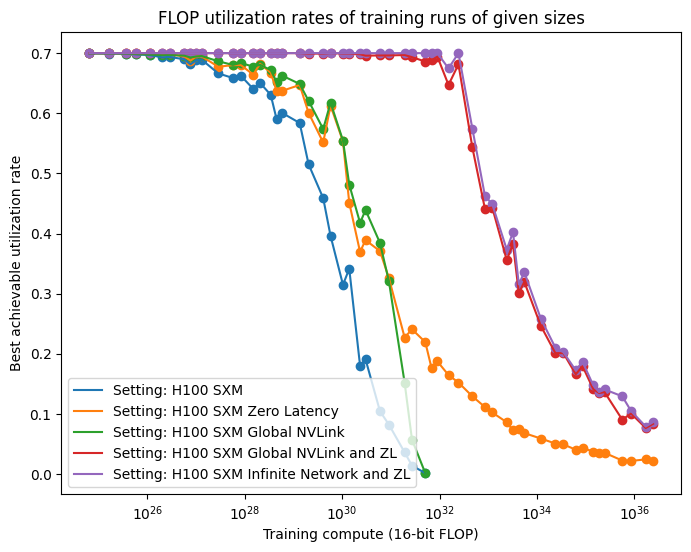

In [10]:
import warnings
warnings.filterwarnings("error")

## set these integers to 1 if you want the associated network communications to be hidden behind computation whenever possible, set them to 0 otherwise
overlap_TP = 1
overlap_PP = 1
overlap_DP = 1

d_model_min = 12288
d_model_max = d_model_min*128

## define the list of d_model values to iterate over when drawing the plots
d_model_list = sorted([f * 2**i for (f, i) in product(range(1, 17, 2), range(11, 22)) if f * 2**i >= d_model_min and f * 2**i <= d_model_max])

seq_len = 2048 ## sequence length to use during training

interleaving = True ## set this flag to True if you want to enable pipeline interleaving, set it to False to disable it
zero_bubble_pp = False ## set this flag to True if you want to enable zero-bubble pipeline parallelism, set it to False to disable it

def simulate_training_runs(gpu, d_model_list, d_ff_list, number_of_layers, calc_sparsity_factor, critical_batch_size, seq_len, years, stopping_utilization_value=0, zero_bubble_pp=False, \
                           overlap_TP=1, overlap_DP=1, overlap_PP=1):
    info_list = []

    for (d_model, d_ff) in zip(d_model_list, d_ff_list):
        print(d_model, d_ff)
        result = cluster_size_required(gpu, d_model, d_ff, number_of_layers, calc_sparsity_factor, critical_batch_size, seq_len, years=years, zero_bubble_pp=zero_bubble_pp, \
                                       overlap_TP=overlap_TP, overlap_DP=overlap_DP, overlap_PP=overlap_PP)

        if result[0] != None:
            N, utilization_opt, best_time_yrs, chinchilla_optimal_compute, local_batch_size, local_layers, local_sparsity_factor = result

            N_DP_opt, N_TP_model_opt, N_TP_ff_opt, N_PP_opt, N_EP_opt, N_DP_tup_opt, N_TP_model_tup_opt, N_TP_ff_tup_opt, N_PP_tup_opt, N_EP_tup_opt, \
            num_of_microbatches_opt, pp_interleaving_factor_opt, recompute_activations_opt, utilization_opt, \
            best_time_yrs, tp_time_opt, dp_time_opt, pp_time_opt, latency_time_opt = \
                    optimal_parallelism(gpu, d_model, d_ff, local_layers, local_sparsity_factor, local_batch_size, seq_len, result[0], zero_bubble_pp, overlap_TP, overlap_DP, overlap_PP, interleaving)

            N_TP_opt = N_TP_model_opt * N_TP_ff_opt
            N_param_local = 2*d_model*d_ff*local_layers*local_sparsity_factor

            info_list.append((d_model, d_ff, N_param_local, local_layers, local_sparsity_factor, local_batch_size*seq_len, chinchilla_optimal_compute, best_time_yrs*12, \
                              utilization_opt, N, N_TP_model_opt, N_TP_ff_opt, N_TP_opt, N_PP_opt, pp_interleaving_factor_opt, N_DP_opt, N_EP_opt, local_sparsity_factor, \
                              N_DP_tup_opt, N_TP_model_tup_opt, N_TP_ff_tup_opt, N_PP_tup_opt, N_EP_tup_opt, \
                              num_of_microbatches_opt, recompute_activations_opt, tp_time_opt, dp_time_opt, pp_time_opt, latency_time_opt))

            if utilization_opt < stopping_utilization_value:
                break
        else:
            break

    return info_list

info_dict = {}
linear_scaling_end_dict = {}

plt.figure(figsize=(8, 6))

for setting in grand_comparison_settings_dense: ## change the list being iterated over here to obtain outputs for different simulation settings
    linear_scaling_regime_ends = None
    gpu = setting.gpu

    print("Simulating training runs for setting: %s" % (setting.identifier))
    d_ff_list = [4*d for d in d_model_list]
    info_dict[setting] = simulate_training_runs(gpu, d_model_list, d_ff_list, number_of_layers=setting.layer_fun, calc_sparsity_factor=setting.sparsity_fun, critical_batch_size=setting.batch_size_fun, \
                                            seq_len=seq_len, years=0.5, stopping_utilization_value=0.001, zero_bubble_pp=zero_bubble_pp, \
                                            overlap_TP=overlap_TP, overlap_DP=overlap_DP, overlap_PP=overlap_PP)
    print("Simulation complete! Results below:\n")
    for info in info_dict[setting]:
        (d_model, d_ff, N_param_local, local_layers, local_sparsity_factor, local_batch_size_tokens, chinchilla_optimal_compute, best_time_months, utilization_opt, N, N_TP_model_opt, N_TP_ff_opt, \
         N_TP_opt, N_PP_opt, pp_interleaving_factor_opt, N_DP_opt, N_EP_opt, local_sparsity_factor, N_DP_tup_opt, N_TP_model_tup_opt, N_TP_ff_tup_opt, N_PP_tup_opt, N_EP_tup_opt, num_of_microbatches_opt, \
         recompute_activations_opt, tp_time_opt, dp_time_opt, pp_time_opt, latency_time_opt) = info

        print("d_model: %.2e\t Params: %.2e\t Layers: %d\t Sparsity: %d\t Batch size (tok): %.2e\t Training: %.2e FLOP, %.2f months\t Util: %.3f\t N_GPU: %.2e\t (%d, %d)=%d TP, %d PP (v=%d), %d DP, %d EP" \
                % (d_model, N_param_local, local_layers, local_sparsity_factor, local_batch_size_tokens, chinchilla_optimal_compute, best_time_months, utilization_opt, N, N_TP_model_opt, N_TP_ff_opt, \
                  N_TP_opt, N_PP_opt, pp_interleaving_factor_opt, N_DP_opt, N_EP_opt))

        print("Parallelism partition across the network hierarchy:")
        print("DP:", N_DP_tup_opt, "TP_m:", N_TP_model_tup_opt, "TP_ff:", N_TP_ff_tup_opt, "PP:", N_PP_tup_opt, "EP:", N_EP_tup_opt)
        print("TP comm time: %.3f months, PP comm time: %.3f months, DP comm time: %.3f months, Network latency time: %.3f months" % \
         (12*tp_time_opt/seconds_in_year, 12*pp_time_opt/seconds_in_year, 12*dp_time_opt/seconds_in_year, 12*latency_time_opt/seconds_in_year))
        print("Number of vertical microbatches: %d, recompute activations: %s" % (num_of_microbatches_opt, str(recompute_activations_opt)))
        print("Individual GPU matmul dimensions: %d, %d, %d\n" % (d_model//N_TP_model_opt, d_ff//N_TP_ff_opt, local_batch_size_tokens//(N_DP_opt*num_of_microbatches_opt*local_sparsity_factor)))

        if (linear_scaling_regime_ends == None) and utilization_opt <= 0.8*(gpu.clock_Hz/gpu.max_clock_Hz):
            linear_scaling_regime_ends = chinchilla_optimal_compute

    compute_list = [info[6] for info in info_dict[setting]]
    utilization_list = [info[8] for info in info_dict[setting]]
    linear_scaling_end_dict[setting] = linear_scaling_regime_ends

    plt.plot(compute_list, utilization_list, label="Setting: %s" % (setting.identifier))
    plt.scatter(compute_list, utilization_list)

for setting in linear_scaling_end_dict:
    if linear_scaling_end_dict[setting] == None:
        print("Linear scaling for %s ends at above %.2e FLOP" % (setting.identifier, max([info[6] for info in info_dict[setting]])))
    else:
        print("Linear scaling for %s ends at %.2e FLOP" % (setting.identifier, linear_scaling_end_dict[setting]))

run_name = "grand_comparison_sparse"

plt.xscale("log")
plt.xlabel("Training compute (16-bit FLOP)")
plt.ylabel("Best achievable utilization rate")
plt.legend()

plt.title("FLOP utilization rates of training runs of given sizes")

plt.savefig("visuals/utilization_plot_%s.png" % (run_name))
plt.savefig("visuals/utilization_plot_%s.pdf" % (run_name))
plt.show()

## Parallelism strategy plots

This cell plots the parallelism strategies used for each setting that was looped over in the previous cell. Running this cell after using the default settings in the previous cell reproduces Figure 8 from the paper.

In [ ]:
fig, axs = plt.subplots(1, len(info_dict), figsize=(15, 5))

for index, setting in enumerate(info_dict):
    tp_frac = []
    pp_frac = []
    dp_frac = []
    ep_frac = []
    compute = []

    for info in info_dict[setting]:
        (d_model, d_ff, N_param_local, local_layers, local_sparsity_factor, local_batch_size_tokens, chinchilla_optimal_compute, best_time_months, utilization_opt, N, N_TP_model_opt, N_TP_ff_opt, \
         N_TP_opt, N_PP_opt, pp_interleaving_factor_opt, N_DP_opt, N_EP_opt, local_sparsity_factor, N_DP_tup_opt, N_TP_model_tup_opt, N_TP_ff_tup_opt, N_PP_tup_opt, N_EP_tup_opt, num_of_microbatches_opt, \
         recompute_activations_opt, tp_time_opt, dp_time_opt, pp_time_opt, latency_time_opt) = info
         
        tp_frac.append(np.log(N_TP_opt)/np.log(N))
        pp_frac.append(np.log(N_PP_opt)/np.log(N))
        dp_frac.append(np.log(N_DP_opt)/np.log(N))       
        ep_frac.append(np.log(N_EP_opt)/np.log(N))
        compute.append(chinchilla_optimal_compute)

        # Plot the first subplot
    axs[index].plot(compute, tp_frac, label="Tensor parallelism")
    axs[index].plot(compute, dp_frac, label="Data parallelism")
    axs[index].plot(compute, pp_frac, label="Pipeline parallelism")
    axs[index].plot(compute, ep_frac, label="Expert parallelism")

    axs[index].set_title("Parallelism strategies for %s" % (setting.identifier))
    axs[index].set_xscale("log")
    axs[index].set_xlabel("Training compute (16-bit FLOP)")
    axs[index].set_ylabel("Parallelism fraction")
    axs[index].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.savefig("visuals/parallelism_strategies_%s.pdf" % (run_name))
plt.savefig("visuals/parallelism_strategies_%s.png" % (run_name))
plt.show()